In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

python inference.py --dataset_location data/nacc_scaled_corrected.csv --dataset_id nacc

python inference.py --dataset_location data/nacc_scaled_corrected.csv --dataset_id nacc --do_single_pass

In [2]:
nacc_diag = pd.read_csv('../data/nacc_diagnosis.csv', index_col=0)
nacc_diag.shape

(5209, 1)

In [3]:
res_df = pd.read_csv('latest_output_nacc_50.csv', index_col=0)
res_df

,mean,std
nacc_id,,
34,0.754137,0.190174
225,0.933381,0.085771
511,0.467415,0.259353
531,0.497308,0.269715
920,0.025401,0.038529
...,...,...
999346,0.985245,0.023443
999546,0.189503,0.176066
999566,0.399080,0.229956


In [4]:
joined_df = res_df.join(nacc_diag, how='inner')
joined_df

,mean,std,diagnosis
nacc_id,,,
34,0.754137,0.190174,AD
225,0.933381,0.085771,OD
511,0.467415,0.259353,AD
531,0.497308,0.269715,OD
920,0.025401,0.038529,Control
...,...,...,...
999346,0.985245,0.023443,AD
999546,0.189503,0.176066,Control
999566,0.399080,0.229956,OND


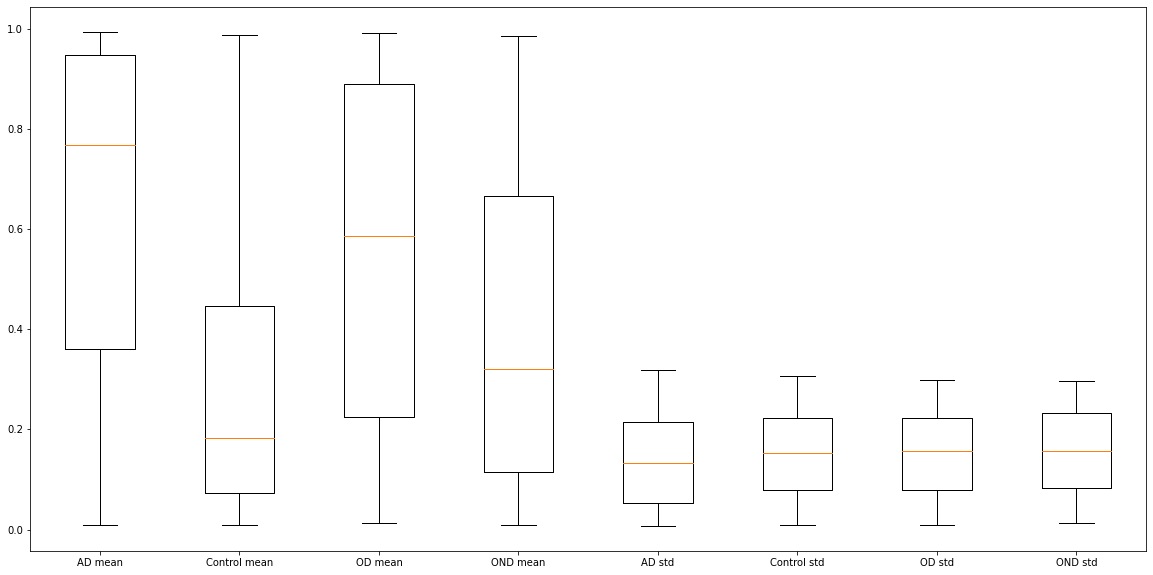

In [5]:
plt.subplots(figsize=(20, 10))
all_data = [joined_df[joined_df.diagnosis == 'AD']['mean'].values, 
            joined_df[joined_df.diagnosis == 'Control']['mean'].values,
            joined_df[joined_df.diagnosis == 'OD']['mean'].values,
            joined_df[joined_df.diagnosis == 'OND']['mean'].values,
            ##
            joined_df[joined_df.diagnosis == 'AD']['std'].values,
            joined_df[joined_df.diagnosis == 'Control']['std'].values,
            joined_df[joined_df.diagnosis == 'OD']['std'].values,
            joined_df[joined_df.diagnosis == 'OND']['std'].values,]


_ = plt.boxplot(all_data, labels=['AD mean', 'Control mean', 'OD mean', 'OND mean', 
                                  'AD std', 'Control std', 'OD std', 'OND std'])
plt.show()
plt.close()

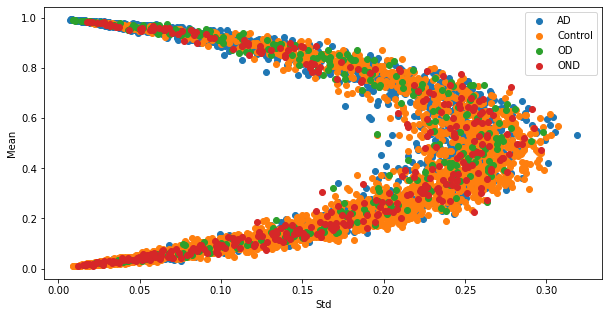

In [8]:
plt.subplots(figsize=(10, 5))

for diagnosis in ['AD', 'Control', 'OD', 'OND']:
    tmp_df = joined_df[joined_df.diagnosis == diagnosis]

    plt.scatter(tmp_df['std'], tmp_df['mean'], label=diagnosis)

plt.legend()
plt.xlabel('Std')
plt.ylabel('Mean')
plt.show()
plt.close()

## MC-Drop vs single-pass: AUC Roc Curve

In [9]:
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


In [10]:
joined_df = joined_df[(joined_df.diagnosis == 'AD') | (joined_df.diagnosis == 'Control')]
joined_df

,mean,std,diagnosis
nacc_id,,,
34,0.754137,0.190174,AD
511,0.467415,0.259353,AD
920,0.025401,0.038529,Control
1006,0.063964,0.061692,Control
1341,0.812855,0.170804,Control
...,...,...,...
998980,0.141004,0.160232,Control
999209,0.154553,0.143639,AD
999346,0.985245,0.023443,AD


In [15]:
joined_df['diagnosis'] = 1 - LabelEncoder().fit_transform(joined_df['diagnosis'].copy())
joined_df

<ipython-input-15-c0d312f72e3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_df['diagnosis'] = 1 - LabelEncoder().fit_transform(joined_df['diagnosis'].copy())


,mean,std,diagnosis
nacc_id,,,
34,0.754137,0.190174,1
511,0.467415,0.259353,1
920,0.025401,0.038529,0
1006,0.063964,0.061692,0
1341,0.812855,0.170804,0
...,...,...,...
998980,0.141004,0.160232,0
999209,0.154553,0.143639,1
999346,0.985245,0.023443,1


In [23]:
single_pass = pd.read_csv('latest_output_nacc_1.csv', index_col=0)
single_pass = single_pass.join(nacc_diag, how='inner')
single_pass = single_pass[(single_pass.diagnosis == 'AD') | (single_pass.diagnosis == 'Control')]
single_pass['diagnosis'] = 1 - LabelEncoder().fit_transform(single_pass['diagnosis'].copy())
single_pass

,mean,std,diagnosis
nacc_id,,,
34,0.846376,NaN,1
511,0.462805,NaN,1
920,0.006656,NaN,0
1006,0.014642,NaN,0
1341,0.941566,NaN,0
...,...,...,...
998980,0.036137,NaN,0
999209,0.052260,NaN,1
999346,0.997336,NaN,1


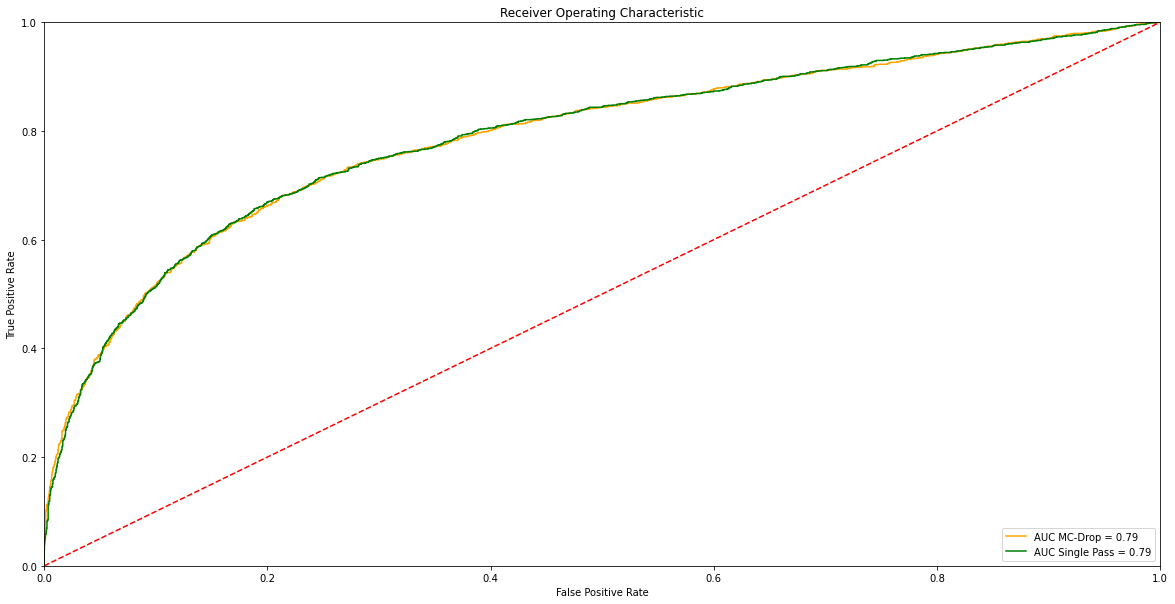

In [25]:

def plot_roc_stuff(tmp_df, label, color):
    preds = tmp_df['mean']
    fpr, tpr, threshold = metrics.roc_curve(tmp_df['diagnosis'], preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, 'b', label = f'AUC {label} = %0.2f' % roc_auc, color=color)

plt.subplots(figsize=(20, 10))
plt.title('Receiver Operating Characteristic')
plot_roc_stuff(joined_df, 'MC-Drop', 'orange')
plot_roc_stuff(single_pass, 'Single Pass', 'green')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.close()

## MC-Drop (uncertainty) vs MC-Drop (delta) vs single-pass (delta)

In [26]:
def populate_arrs_for_df(df, accs_arr, sens_arr, spes_arr, people_arr):
    probs = tmp_df['mean'].values
    probs[probs < 0.5] = 0
    probs[probs > 0.5] = 1
    
    tn, fp, fn, tp = metrics.confusion_matrix(tmp_df['diagnosis'].values, probs).ravel()
    specificity = tn / (tn+fp)
    sensitivty = tp / (tp+fn)
    
    accs_arr.append(metrics.accuracy_score(tmp_df['diagnosis'].values, probs))
    sens_arr.append(sensitivty)
    spes_arr.append(specificity)
    people_arr.append(tmp_df.shape[0])
    

### MC-Drop with uncertainty thresholding

In [27]:
accs = []
sens = []
spes = []
people = []
for std_val in np.arange(0.015, 0.36, 0.001):
    
    tmp_df = joined_df.loc[joined_df['std'] < std_val, :]
    populate_arrs_for_df(tmp_df, accs, sens, spes, people)

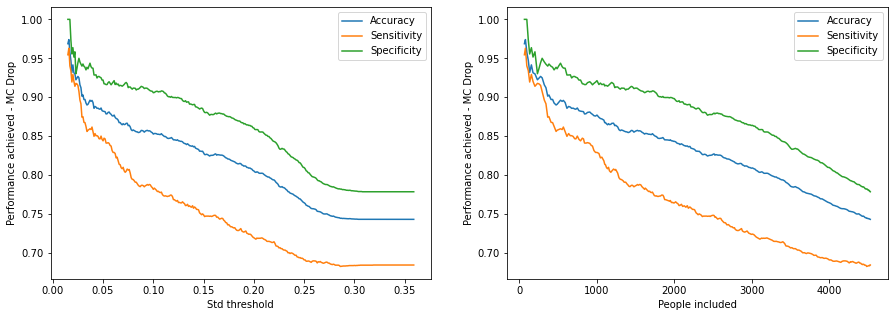

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(np.arange(0.015, 0.36, 0.001), accs, label='Accuracy')
axs[0].plot(np.arange(0.015, 0.36, 0.001), sens, label='Sensitivity')
axs[0].plot(np.arange(0.015, 0.36, 0.001), spes, label='Specificity')
axs[0].set_xlabel('Std threshold')
axs[0].set_ylabel('Performance achieved - MC Drop')
axs[0].legend()

axs[1].plot(people, accs, label='Accuracy')
axs[1].plot(people, sens, label='Sensitivity')
axs[1].plot(people, spes, label='Specificity')
axs[1].set_xlabel('People included')
axs[1].set_ylabel('Performance achieved - MC Drop')
axs[1].legend()

plt.show()

### MC-Drop vs Single-pass with probability-delta thresholding

In [29]:
accs_delta_mc, accs_delta_1 = [], []
sens_delta_mc, sens_delta_1 = [], []
spes_delta_mc, spes_delta_1 = [], []
people_delta_mc, people_delta_1 = [], []

for delta_val in np.arange(0.012, 0.51, 0.001):

    tmp_df = joined_df.loc[(joined_df['mean'] < delta_val) | (joined_df['mean'] > 1- delta_val), :]
    populate_arrs_for_df(tmp_df, accs_delta_mc, sens_delta_mc, spes_delta_mc, people_delta_mc)
    
    tmp_df = single_pass.loc[(single_pass['mean'] < delta_val) | (single_pass['mean'] > 1- delta_val), :]
    populate_arrs_for_df(tmp_df, accs_delta_1, sens_delta_1, spes_delta_1, people_delta_1)

In [31]:
def plot_across_metrics(x_vals_mc, x_vals_1, x_label):
    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    axs[0].plot(x_vals_mc, accs_delta_mc, label='Accuracy - MC Drop')
    axs[0].plot(x_vals_1, accs_delta_1, label='Accuracy - Single')

    axs[1].plot(x_vals_mc, sens_delta_mc, label='Sensitivity - MC Drop')
    axs[1].plot(x_vals_1, sens_delta_1, label='Sensitivity - Single')

    axs[2].plot(x_vals_mc, spes_delta_mc, label='Specificity - MC Drop')
    axs[2].plot(x_vals_1, spes_delta_1, label='Specificity - Single')

    for ax in axs:
        ax.set_xlabel(x_label)
        ax.set_ylabel('Performance achieved')
        ax.legend()
    
    plt.show()

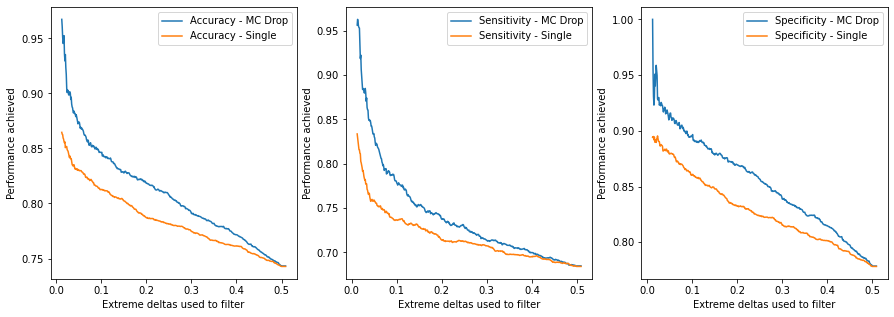

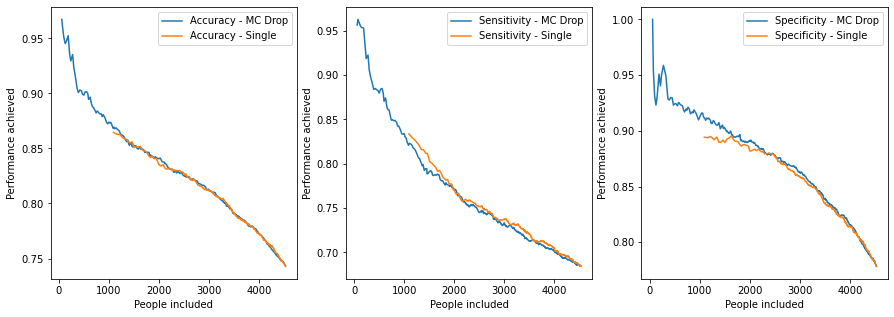

In [32]:
plot_across_metrics(np.arange(0.012, 0.51, 0.001), np.arange(0.012, 0.51, 0.001), 'Extreme deltas used to filter')
plot_across_metrics(people_delta_mc, people_delta_1, 'People included')


## Comparing the three approaches across people included

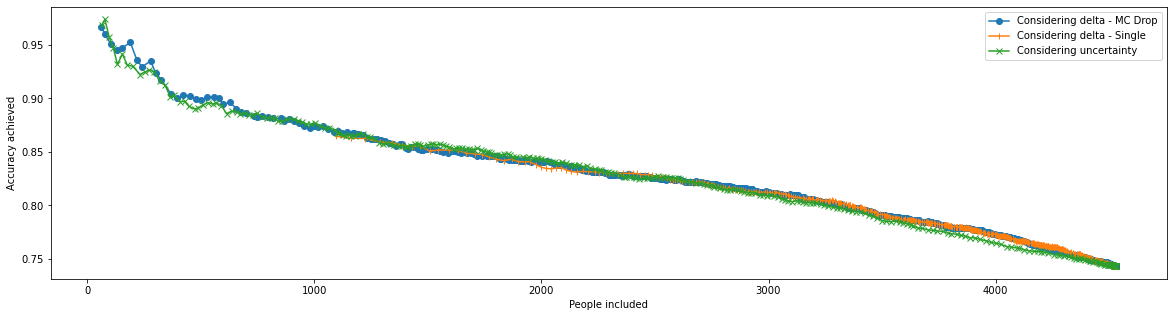

In [33]:
plt.subplots(figsize=(20,5))
plt.plot(people_delta_mc, accs_delta_mc, 'o-', label='Considering delta - MC Drop')
plt.plot(people_delta_1, accs_delta_1, '|-', label='Considering delta - Single')
plt.plot(people, accs, 'x-', label='Considering uncertainty')
plt.xlabel('People included')
plt.ylabel('Accuracy achieved')
plt.legend()
plt.show()

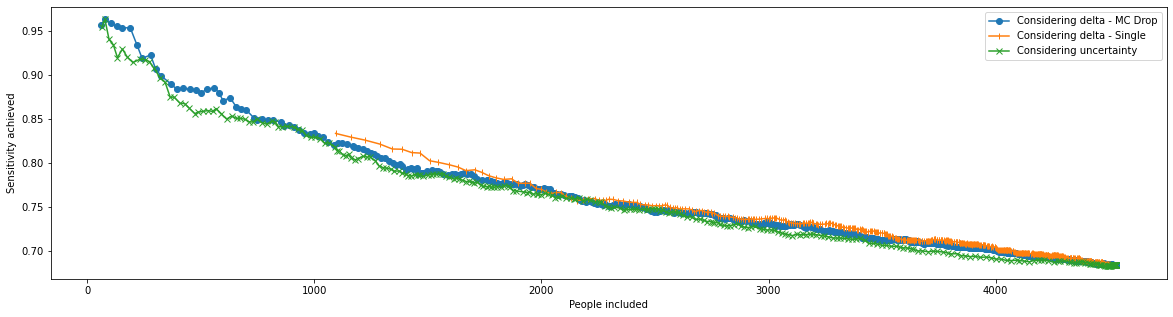

In [34]:
plt.subplots(figsize=(20,5))
plt.plot(people_delta_mc, sens_delta_mc, 'o-', label='Considering delta - MC Drop')
plt.plot(people_delta_1, sens_delta_1, '|-', label='Considering delta - Single')
plt.plot(people, sens, 'x-', label='Considering uncertainty')
plt.xlabel('People included')
plt.ylabel('Sensitivity achieved')
plt.legend()
plt.show()

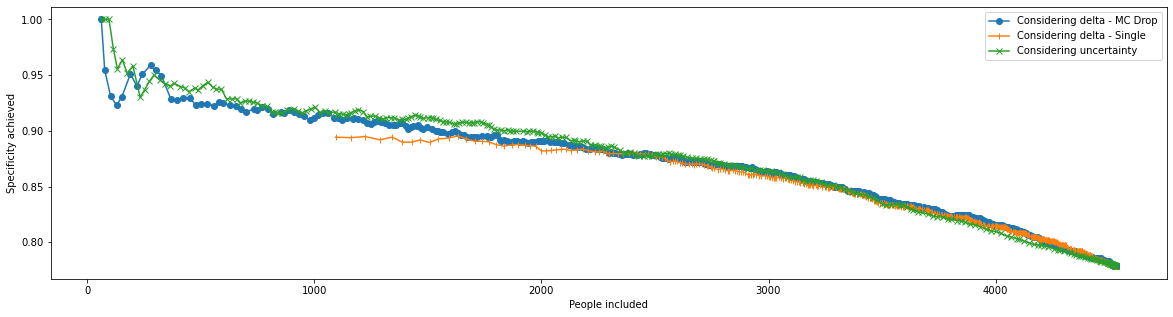

In [35]:
plt.subplots(figsize=(20,5))
plt.plot(people_delta_mc, spes_delta_mc, 'o-', label='Considering delta - MC Drop')
plt.plot(people_delta_1, spes_delta_1, '|-', label='Considering delta - Single')
plt.plot(people, spes, 'x-', label='Considering uncertainty')
plt.xlabel('People included')
plt.ylabel('Specificity achieved')
plt.legend()
plt.show()